# Stores Sales Prediction Notebook

In [2]:
#Step 1: Import Libraries and Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

# Load the dataset from Excel file
data = pd.read_excel('D:/HUMANITICS/stores_sales.xlsx')

In [2]:
# Step 2: Data Exploration and Visualization
# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(data.head())

First few rows of the dataset:
   store       date  weekly_sales  holiday_flag  temperature  fuel_Price  \
0      1 2010-02-05    1643690.90             0        42.31       2.572   
1      1 2010-02-12    1641957.44             1        38.51       2.548   
2      1 2010-02-19    1611968.17             0        39.93       2.514   
3      1 2010-02-26    1409727.59             0        46.63       2.561   
4      1 2010-03-05    1554806.68             0        46.50       2.625   

          cpi  unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  


In [3]:
# Display general information about the dataset
print("\nDataset information:")
print(data.info())


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   store         6435 non-null   int64         
 1   date          6435 non-null   datetime64[ns]
 2   weekly_sales  6435 non-null   float64       
 3   holiday_flag  6435 non-null   int64         
 4   temperature   6435 non-null   float64       
 5   fuel_Price    6435 non-null   float64       
 6   cpi           6435 non-null   float64       
 7   unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB
None


In [4]:
# Summary statistics of numerical features
print("\nSummary statistics of numerical features:")
print(data.describe())


Summary statistics of numerical features:
             store  weekly_sales  holiday_flag  temperature   fuel_Price  \
count  6435.000000  6.435000e+03   6435.000000  6435.000000  6435.000000   
mean     23.000000  1.046965e+06      0.069930    60.663782     3.358607   
std      12.988182  5.643666e+05      0.255049    18.444933     0.459020   
min       1.000000  2.099862e+05      0.000000    -2.060000     2.472000   
25%      12.000000  5.533501e+05      0.000000    47.460000     2.933000   
50%      23.000000  9.607460e+05      0.000000    62.670000     3.445000   
75%      34.000000  1.420159e+06      0.000000    74.940000     3.735000   
max      45.000000  3.818686e+06      1.000000   100.140000     4.468000   

               cpi  unemployment  
count  6435.000000   6435.000000  
mean    171.578394      7.999151  
std      39.356712      1.875885  
min     126.064000      3.879000  
25%     131.735000      6.891000  
50%     182.616521      7.874000  
75%     212.743293      8.6

<Figure size 1000x800 with 0 Axes>

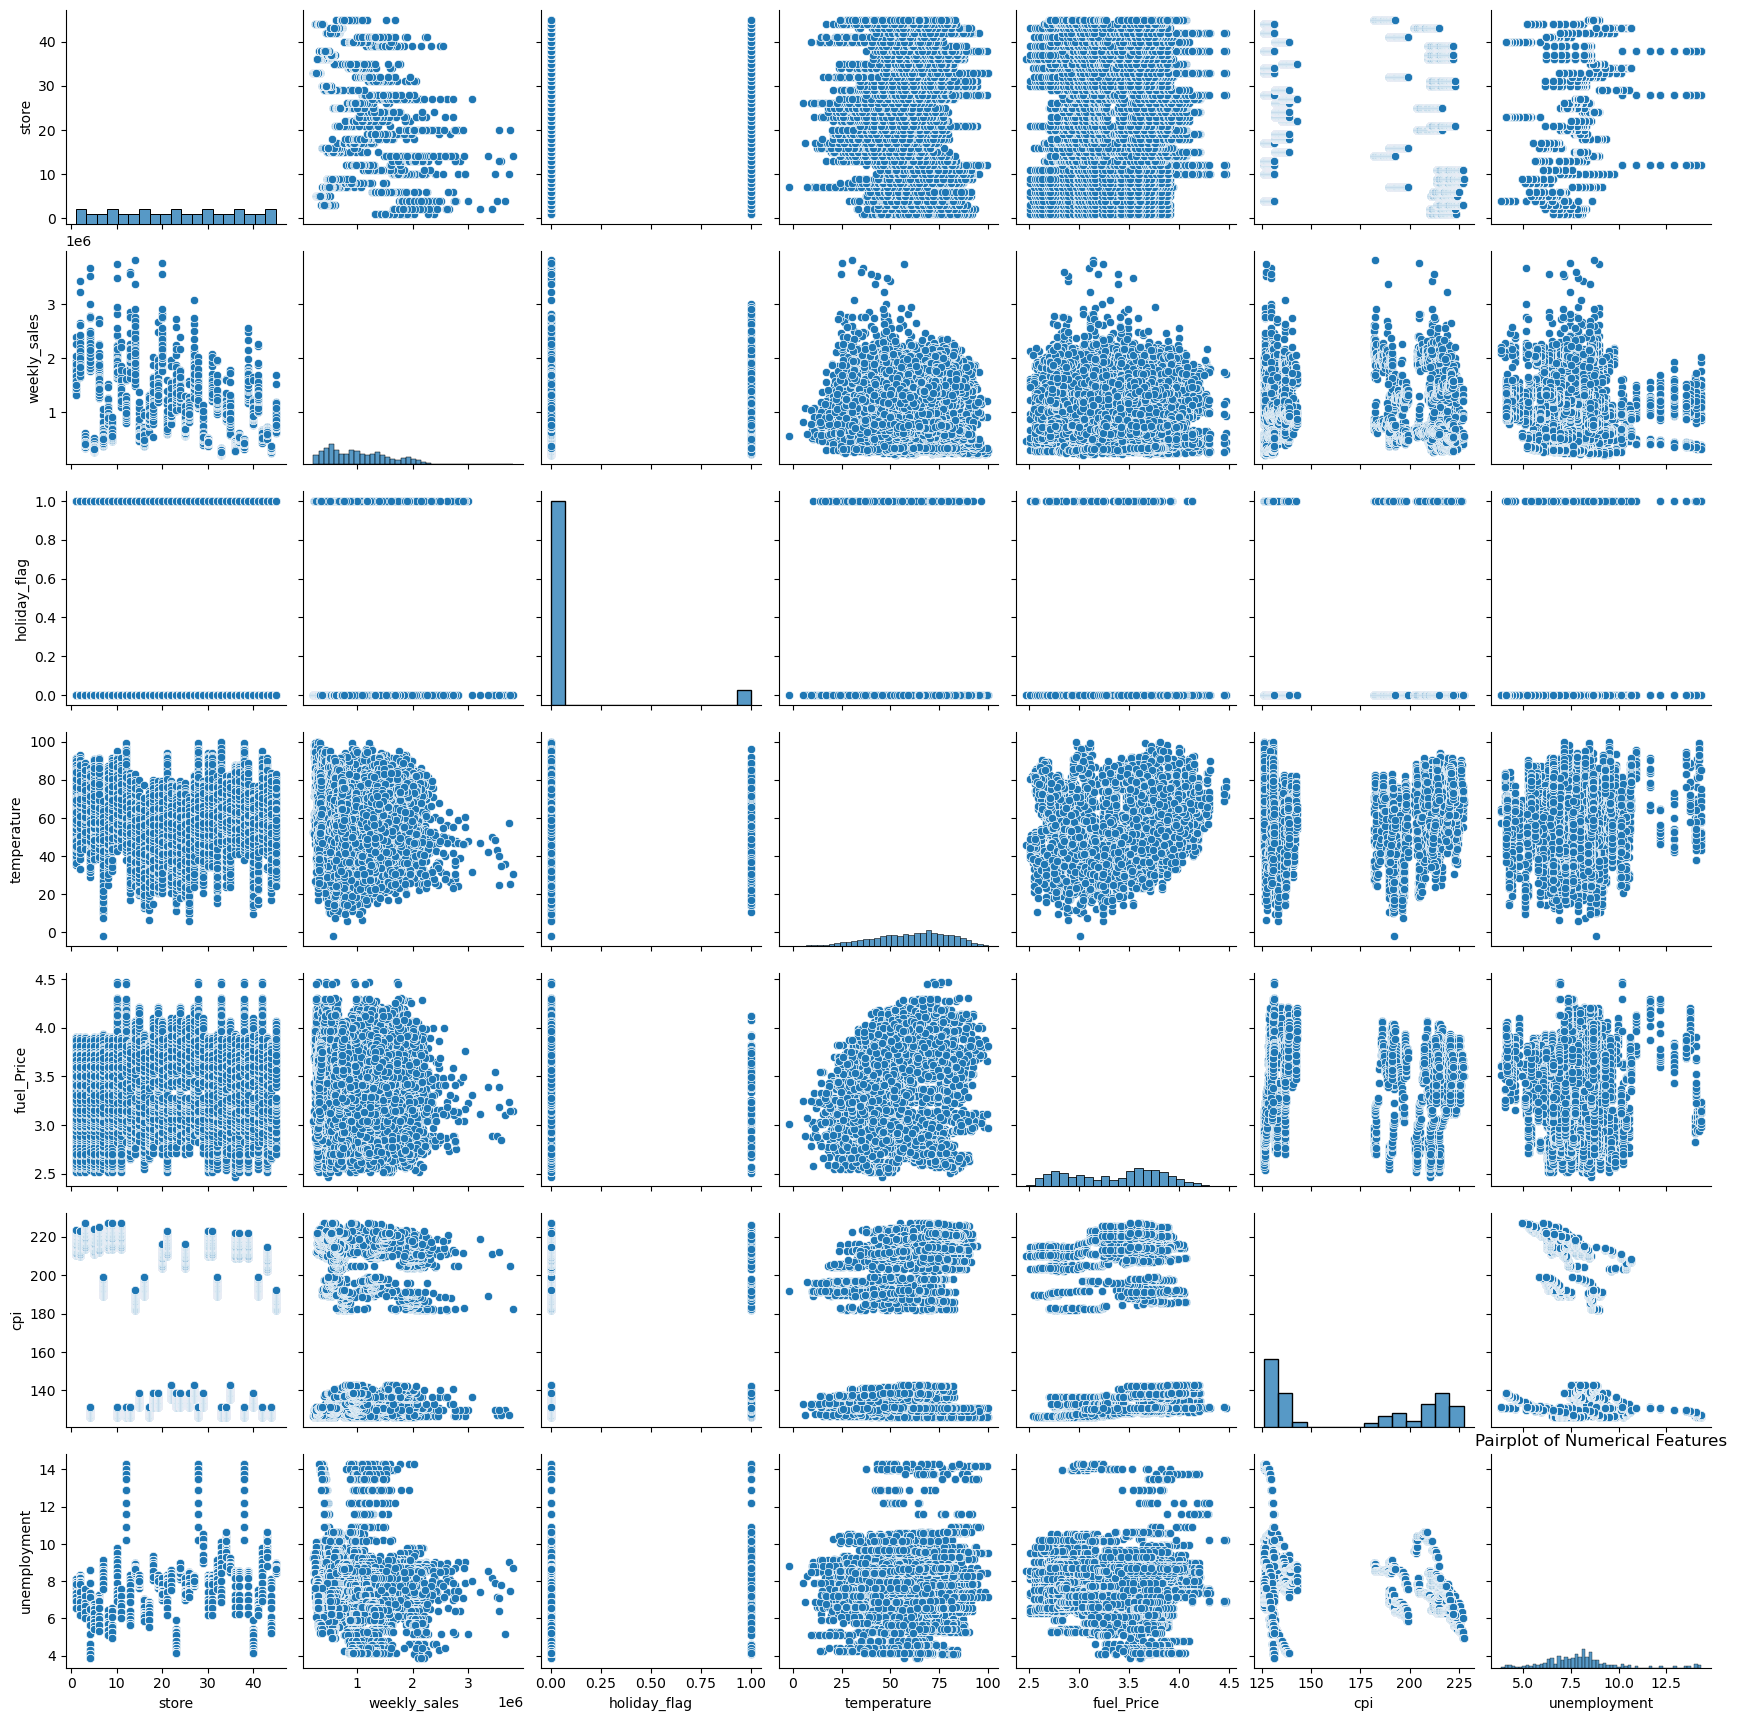

In [5]:
# Visualizing Relationships between Features

# Pairplot for numerical features
plt.figure(figsize=(10, 8))
sns.pairplot(data)
plt.title("Pairplot of Numerical Features")
plt.show()


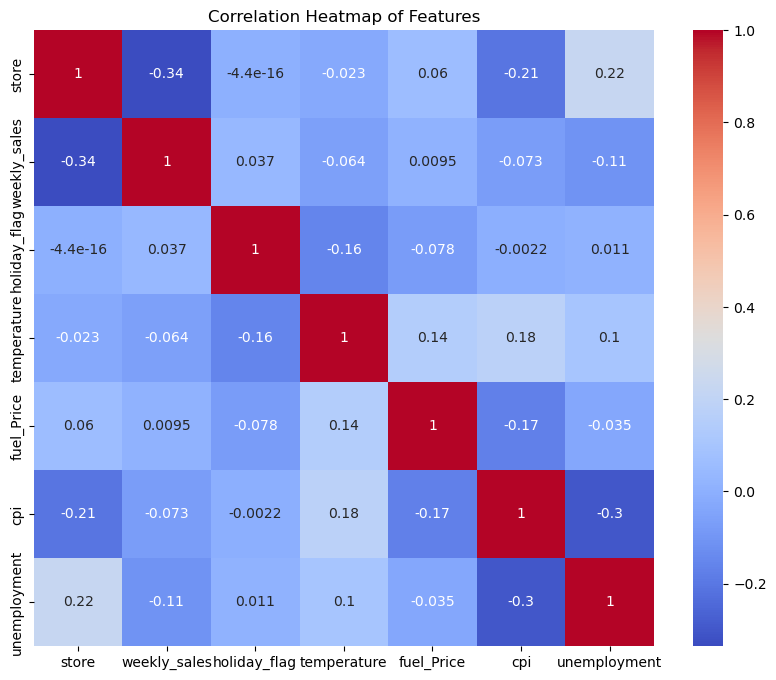

In [6]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Features")
plt.show()

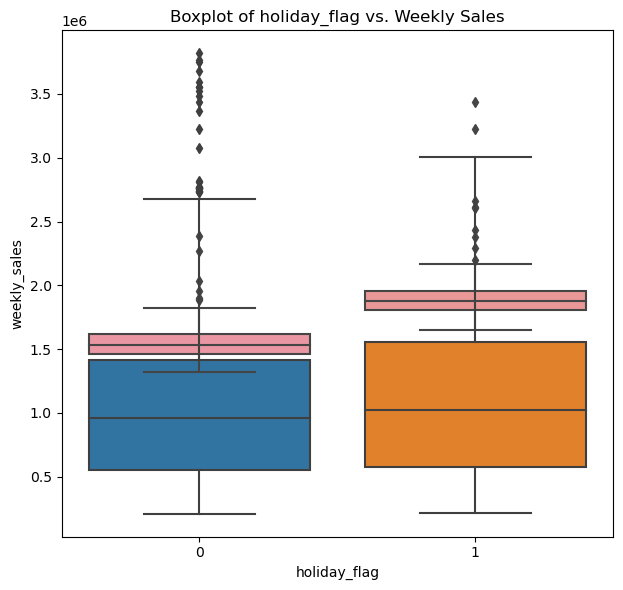

In [7]:
# Boxplot for categorical features vs. target
plt.figure(figsize=(12, 6))
for feature in ['store', 'holiday_flag']:
    plt.subplot(1, 2, 1)
    sns.boxplot(x=feature, y='weekly_sales', data=data)
    plt.title(f"Boxplot of {feature} vs. Weekly Sales")
plt.tight_layout()
plt.show()

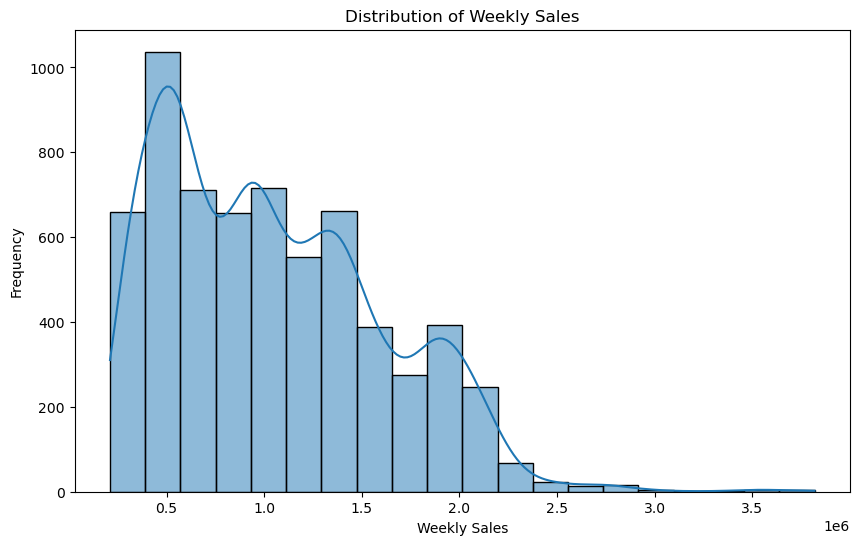

In [8]:
# Distribution of Target Variable
plt.figure(figsize=(10, 6))
sns.histplot(data['weekly_sales'], bins=20, kde=True)
plt.title("Distribution of Weekly Sales")
plt.xlabel("Weekly Sales")
plt.ylabel("Frequency")
plt.show()

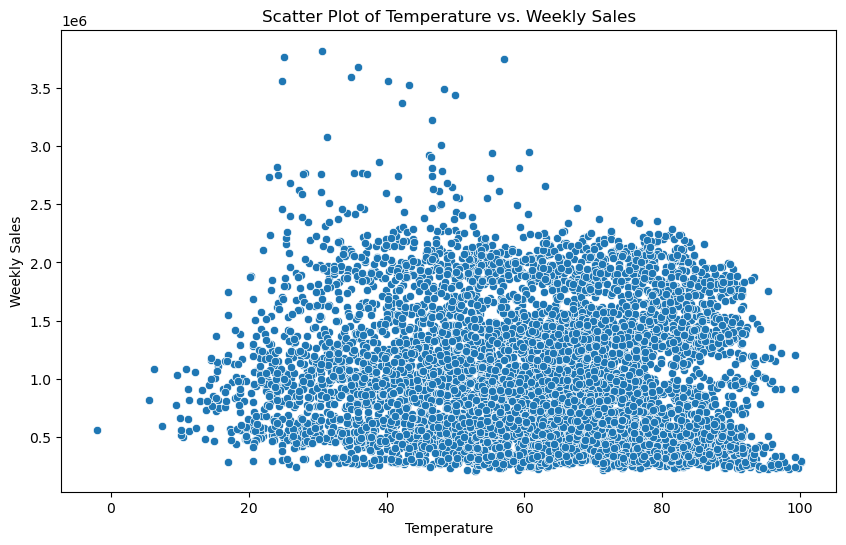

In [11]:
# Scatter plot of temperature vs. weekly sales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temperature', y='weekly_sales', data=data)
plt.title("Scatter Plot of Temperature vs. Weekly Sales")
plt.xlabel("Temperature")
plt.ylabel("Weekly Sales")
plt.show()

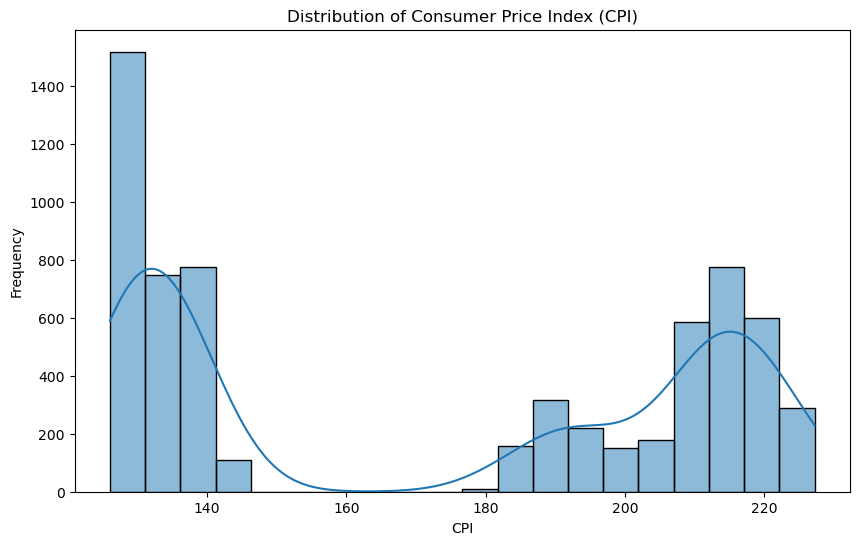

In [14]:
# Distribution of CPI (Consumer Price Index)
plt.figure(figsize=(10, 6))
sns.histplot(data['cpi'], bins=20, kde=True)
plt.title("Distribution of Consumer Price Index (CPI)")
plt.xlabel("CPI")
plt.ylabel("Frequency")
plt.show()

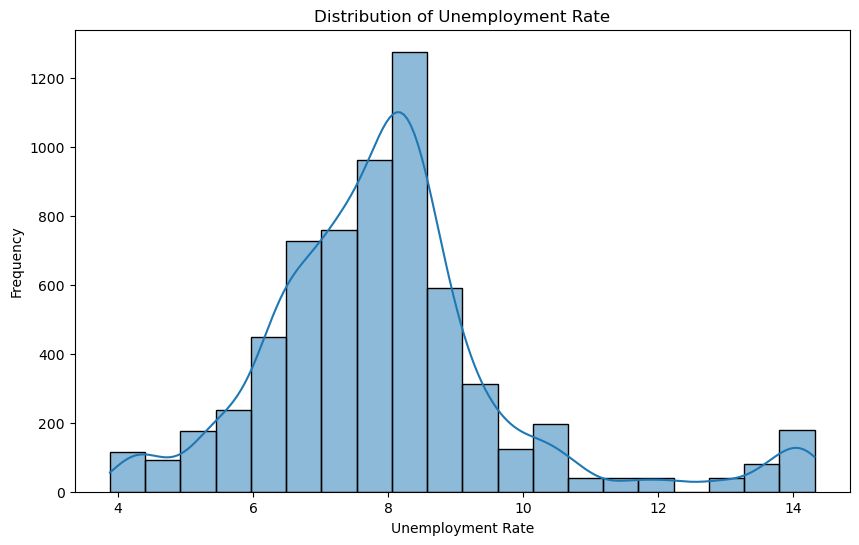

In [16]:
# Distribution of Unemployment Rate
plt.figure(figsize=(10, 6))
sns.histplot(data['unemployment'], bins=20, kde=True)
plt.title("Distribution of Unemployment Rate")
plt.xlabel("Unemployment Rate")
plt.ylabel("Frequency")
plt.show()

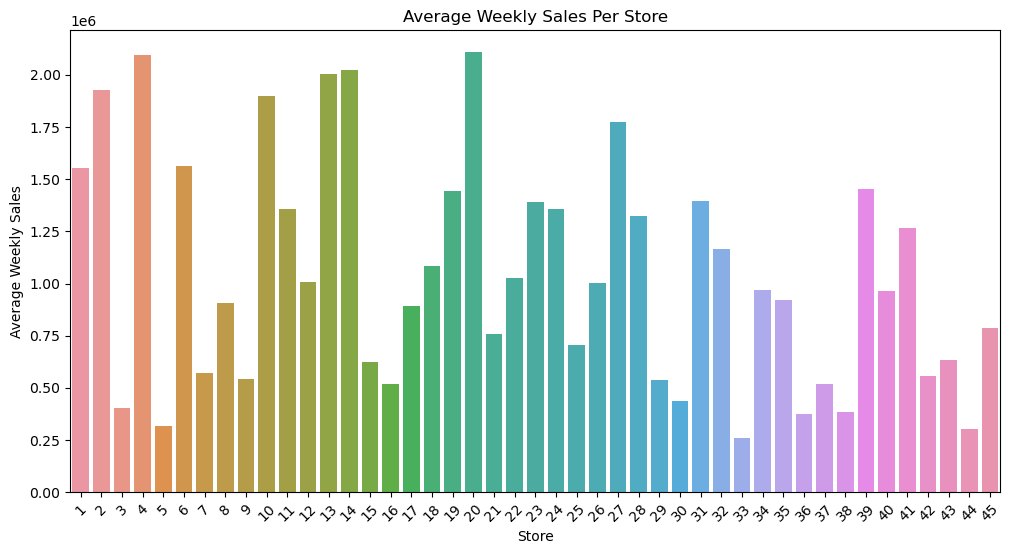

In [22]:
# Average weekly sales per store
store_sales = data.groupby('store')['weekly_sales'].mean().reset_index()

# Bar plot of average weekly sales per store
plt.figure(figsize=(12, 6))
sns.barplot(x='store', y='weekly_sales', data=store_sales)
plt.title("Average Weekly Sales Per Store")
plt.xlabel("Store")
plt.ylabel("Average Weekly Sales")
plt.xticks(rotation=45)
plt.show()

In [29]:
# Step 3: Data Preprocessing and Feature Engineering

# Feature engineering: Extract year, month, and day from date
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

# Create a new feature for days since the beginning of the dataset
data['days_since_start'] = (data['date'] - data['date'].min()).dt.days

# Standardization of numerical features
scaler = StandardScaler()
numerical_features = ['temperature', 'fuel_Price', 'cpi', 'unemployment', 'days_since_start']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Feature selection experimentation
selected_features = ['store', 'holiday_flag', 'temperature', 'fuel_Price', 'cpi', 'unemployment', 'year', 'month', 'day', 'days_since_start']

# Try removing one feature at a time and evaluate model performance
for feature in selected_features:
    features_to_test = [feat for feat in selected_features if feat != feature]
    X = data[features_to_test]
    y = data['weekly_sales']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Build and evaluate the model here
    # using XGBoost(this was just for testing):
    xgb_params = {
        'n_estimators': 100,
        'max_depth': 5,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'objective': 'reg:squarederror',
        'random_state': 42
    }
    xgb_model = xgb.XGBRegressor(**xgb_params)
    xgb_model.fit(X_train, y_train)
    xgb_predictions = xgb_model.predict(X_test)
    rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
    r2 = r2_score(y_test, xgb_predictions)  # Use a different variable name for R2 score
    
    # Print model performance metrics for comparison
    print(f"Model performance without {feature}:")
    print("RMSE:", rmse)
    print("R2 Score:", r2)
    print("="*30)


Model performance without store:
RMSE: 464271.63467141415
R2 Score: 0.3309169745723457
Model performance without holiday_flag:
RMSE: 104977.42466679511
R2 Score: 0.9657920113526813
Model performance without temperature:
RMSE: 108472.97485394096
R2 Score: 0.9634759597864421
Model performance without fuel_Price:
RMSE: 105002.77350227174
R2 Score: 0.965775488993289
Model performance without cpi:
RMSE: 105155.82167058086
R2 Score: 0.9656756475147671
Model performance without unemployment:
RMSE: 105858.05799406477
R2 Score: 0.9652156769685535
Model performance without year:
RMSE: 104876.60570142664
R2 Score: 0.9658576856238008
Model performance without month:
RMSE: 115441.94521335393
R2 Score: 0.9586321468708827
Model performance without day:
RMSE: 113339.86035595238
R2 Score: 0.9601249668459247
Model performance without days_since_start:
RMSE: 103098.3582548474
R2 Score: 0.9670056778896503


Now I am going to try to minimize the RMSE for better predictions.

In [30]:
#Step 4: Model Selection and Hyperparameter Tuning

# Feature engineering: Extract year, month, and day from date
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

# Advanced Feature Engineering
data['days_since_start'] = (data['date'] - data['date'].min()).dt.days
scaler = StandardScaler()
numerical_features = ['temperature', 'fuel_Price', 'cpi', 'unemployment', 'days_since_start']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Selected features based on insights
selected_features = ['store', 'temperature', 'fuel_Price', 'cpi', 'unemployment', 'month', 'days_since_start']

# Split the data into training and testing sets
X = data[selected_features]
y = data['weekly_sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost model
xgb_params = {
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'random_state': 42
}
xgb_model = xgb.XGBRegressor(**xgb_params)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
r2 = r2_score(y_test, xgb_predictions)

# Print model performance metrics
print("XGBoost Model Performance:")
print("RMSE:", rmse)
print("R2 Score:", r2)


XGBoost Model Performance:
RMSE: 120361.19896580961
R2 Score: 0.9550314668582838


Final XGBoost Model Performance:
RMSE: 120361.19896580961
R2 Score: 0.9550314668582838


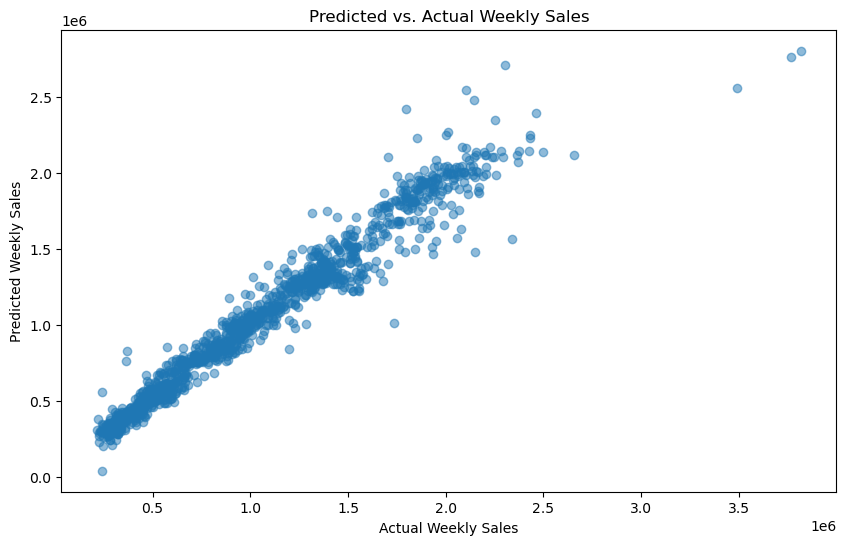

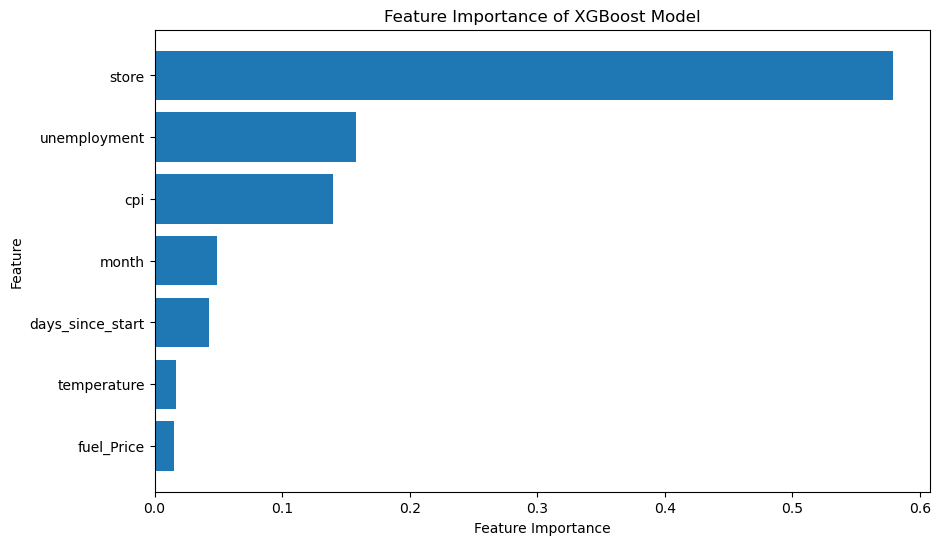

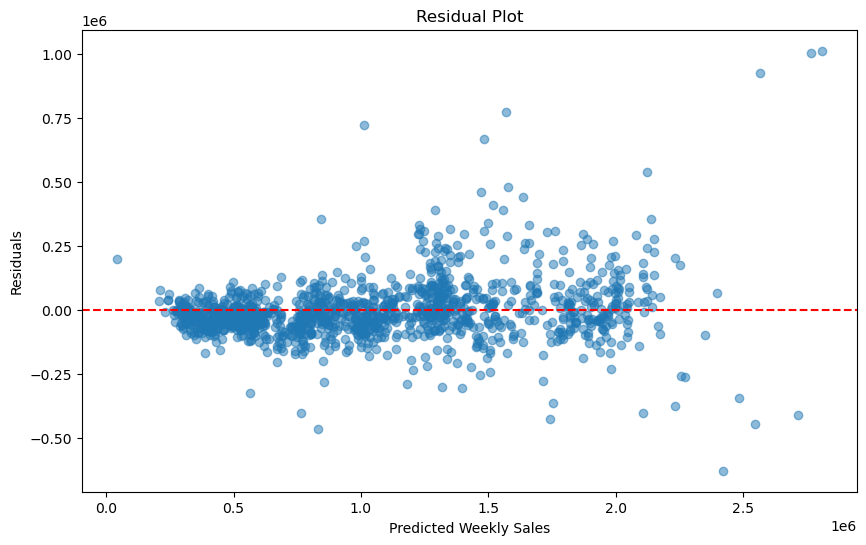

In [31]:
# Step 5: Model Evaluation and Interpretation

# Evaluate the final model on the test set
final_xgb_predictions = xgb_model.predict(X_test)
final_rmse = mean_squared_error(y_test, final_xgb_predictions, squared=False)
final_r2 = r2_score(y_test, final_xgb_predictions)

# Print final model performance metrics
print("Final XGBoost Model Performance:")
print("RMSE:", final_rmse)
print("R2 Score:", final_r2)

# Visualize predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, final_xgb_predictions, alpha=0.5)
plt.title("Predicted vs. Actual Weekly Sales")
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.show()

# Feature Importance
feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [selected_features[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of XGBoost Model')
plt.show()

# Residual Plot
residuals = y_test - final_xgb_predictions

plt.figure(figsize=(10, 6))
plt.scatter(final_xgb_predictions, residuals, alpha=0.5)
plt.title("Residual Plot")
plt.xlabel("Predicted Weekly Sales")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


In [33]:

# Step 6: Model Improvement using Cross-Validation

# Define the XGBoost model with the tuned hyperparameters
improved_xgb_params = {
    'n_estimators': 200,
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'random_state': 42
}
improved_xgb_model = xgb.XGBRegressor(**improved_xgb_params)

# Perform cross-validation and calculate performance metrics
cv_rmse = np.sqrt(-cross_val_score(improved_xgb_model, X, y, cv=5, scoring='neg_mean_squared_error'))
cv_r2 = cross_val_score(improved_xgb_model, X, y, cv=5, scoring='r2')

# Print cross-validation results
print("Cross-Validation Results:")
print("RMSE:", cv_rmse)
print("R2 Score:", cv_r2)

# Print mean and standard deviation of cross-validation results
print("\nMean RMSE:", cv_rmse.mean())
print("Standard Deviation RMSE:", cv_rmse.std())
print("\nMean R2 Score:", cv_r2.mean())
print("Standard Deviation R2 Score:", cv_r2.std())


Cross-Validation Results:
RMSE: [894798.52594634 708322.26474024 537304.99363938 547944.33303669
 547127.71288534]
R2 Score: [-0.78110363 -0.45456406 -0.27078956 -0.67708992 -0.97775641]

Mean RMSE: 647099.5660495982
Standard Deviation RMSE: 139272.37583855176

Mean R2 Score: -0.6322607144565302
Standard Deviation R2 Score: 0.24729280032160889


The negative R2 scores and high RMSE values from cross-validation indicate that 
the improved XGBoost model is not performing well on the dataset.

In [36]:
#hyperparameter tuning using GridSearchCV for the XGBoost model
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Create an XGBoost regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Initialize GridSearchCV with XGBoost model and parameter grid
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator from grid search
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

# Make predictions using the best model
best_xgb_predictions = best_xgb_model.predict(X_test)

# Calculate RMSE and R2 score for the best model
best_rmse = mean_squared_error(y_test, best_xgb_predictions, squared=False)
best_r2_score = r2_score(y_test, best_xgb_predictions)

# Print the best parameters and performance metrics
print("Best Parameters:", best_params)
print("Best Model RMSE:", best_rmse)
print("Best Model R2 Score:", best_r2_score)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Best Model RMSE: 96788.1989450149
Best Model R2 Score: 0.9709209290091219


In [3]:
# Feature engineering: Extract year, month, and day from date
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

# Feature selection
features = ['store', 'holiday_flag', 'temperature', 'fuel_Price', 'cpi', 'unemployment', 'year', 'month', 'day']
X = data[features]
y = data['weekly_sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create base models
xgb_model = xgb.XGBRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
linear_model = LinearRegression()
lgb_model = lgb.LGBMRegressor(random_state=42)  # Add LightGBM model

# Create a Stacking ensemble model
estimators = [
    ('xgb', xgb_model),
    ('rf', rf_model),
    ('linear', linear_model),
    ('lgb', lgb_model)  # Add LightGBM to estimators
]
stacking_model = StackingRegressor(estimators=estimators, final_estimator=xgb_model)

# Define hyperparameters for Stacking model (including LightGBM)
param_grid = {
    'final_estimator__n_estimators': [100, 200],
    'final_estimator__max_depth': [3, 5, 7],
    'final_estimator__learning_rate': [0.01, 0.1, 0.2],

    # Hyperparameters specific to LightGBM
    'final_estimator__lgb__n_estimators': [100, 200],
    'final_estimator__lgb__max_depth': [3, 5, 7],
    'final_estimator__lgb__learning_rate': [0.01, 0.1, 0.2]
} 

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(stacking_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best Stacking model from the grid search
best_stacking_model = grid_search.best_estimator_

# Make predictions
stacking_predictions = best_stacking_model.predict(X_test)

# Calculate RMSE
stacking_rmse = mean_squared_error(y_test, stacking_predictions, squared=False)
print("Stacking Root Mean Squared Error:", stacking_rmse)

# Save predictions to output Excel file
output_excel_file_stacking = 'D:/HUMANITICS/predictions_stacking.xlsx'
output_df_stacking = pd.DataFrame({'Actual': y_test, 'Predicted': stacking_predictions})
output_df_stacking.to_excel(output_excel_file_stacking, index=False)
print("Stacking Predictions saved to", output_excel_file_stacking)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1106
[LightGBM] [Info] Number of data points in the train set: 5148, number of used features: 9
[LightGBM] [Info] Start training from score 1044996.414472
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1107
[LightGBM] [Info] Number of data points in the train set: 4118, number of used features: 9
[LightGBM] [Info] Start training from score 1042845.825662
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points